## Pulse Rate Estimation Algorithm for Wearable Device


**Dataset**

https://arxiv.org/abs/1409.5181

**References**

This work was completed in Udacity's AI for Healthcare Nanodegree Program.

In [13]:
import glob
import numpy as np
import scipy as sp
import scipy.io
import scipy.signal
import matplotlib.pyplot as plt


def LoadTroikaDataset():
    """
    [Function provided by Udacity]
    Retrieve the .mat filenames for the troika dataset.
    Review the README in ./datasets/troika/ to understand the organization of the .mat files.
    Returns:
        data_fls: Names of the .mat files that contain signal data
        ref_fls: Names of the .mat files that contain reference data
        <data_fls> and <ref_fls> are ordered correspondingly, so that ref_fls[5] is the 
            reference data for data_fls[5], etc...
    """
    data_dir = "./datasets/troika/training_data"
    data_fls = sorted(glob.glob(data_dir + "/DATA_*.mat"))
    ref_fls = sorted(glob.glob(data_dir + "/REF_*.mat"))
    return data_fls, ref_fls

def LoadTroikaDataFile(data_fl):
    """
    [Function provided by Udacity]
    Loads and extracts signals from a troika data file.
    Usage:
        data_fls, ref_fls = LoadTroikaDataset()
        ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])
    Args:
        data_fl: (str) filepath to a troika .mat file.
    Returns:
        numpy arrays for ppg, accx, accy, accz signals.
    """
    data = sp.io.loadmat(data_fl)['sig']
    return data[2:]

def AggregateErrorMetric(pr_errors, confidence_est):
    """
    [Function provided by Udacity]
    Computes an aggregate error metric based on confidence estimates.
    Computes the MAE at 90% availability. 
    Args:
        pr_errors: a numpy array of errors between pulse rate estimates and corresponding 
            reference heart rates.
        confidence_est: a numpy array of confidence estimates for each pulse rate
            error.
    Returns:
        the MAE at 90% availability
    """
    # Higher confidence means a better estimate. The best 90% of the estimates
    # are above the 10th percentile confidence.
    percentile90_confidence = np.percentile(confidence_est, 10)
    # Find the errors of the best pulse rate estimates
    best_estimates = pr_errors[confidence_est >= percentile90_confidence]
    # Return the mean absolute error
    return np.mean(np.abs(best_estimates))


def Evaluate():
    """
    [Function provided by Udacity]
    Top-level function evaluation function.
    Runs the pulse rate algorithm on the Troika dataset and returns an aggregate error metric.
    Returns:
        Pulse rate error on the Troika dataset. See AggregateErrorMetric.
    """
    # Retrieve dataset files
    data_fls, ref_fls = LoadTroikaDataset()
    errs, confs = [], []
    for data_fl, ref_fl in zip(data_fls, ref_fls):
        # Run the pulse rate algorithm on each trial in the dataset
        errors, confidence = RunPulseRateAlgorithm(data_fl, ref_fl)
        errs.append(errors)
        confs.append(confidence)
        # Compute aggregate error metric
    errs = np.hstack(errs)
    confs = np.hstack(confs)
    return AggregateErrorMetric(errs, confs)


def ExtractSpectrumPeaks(signal, fft_freq):
    """
    Find the indeces of the peaks in the spectrum of the signal
    Args:
        signal - the data signal (ppg, accx, accy, accz, or acc)
        fft_freq - the frequency values of FFT
    Outputs:
        signal_pks - (1d ndarray) indeces of the peaks in spectrum
        signal_fft - (1d ndarray) FFT of the signal
    """
    # FFT the signal
    signal_fft = np.abs(np.fft.rfft(signal))
    
    # bandpass: erase values outside of [40 BPM, 240 BPM]
    for j, f in enumerate(fft_freq):
        if f <= 40/60.0 or f >= 240/60.0:
            signal_fft[j] = 0
            
    # detect peaks in the spectrum, convert to list
    signal_pks = scipy.signal.find_peaks(signal_fft)[0].tolist()
    
    # sort the peaks by their heights (descending)
    signal_pks.sort(reverse=True, key=lambda x: signal_fft[x])
    
    return np.array(signal_pks), signal_fft
    

def RunPulseRateAlgorithm(data_fl, ref_fl):
    """
    Main code. Estimate the pulse rate and the confidence score.
    
    Args:
        data_fl: Troika dataset (data)
        ref_fl Troika dataset (ref)
        
    Outputs:
        errors: (1d ndarray) absolute error of the algorithm
        confidence: (1d ndarray) self-defined confidence score
    """
    # sampling rate
    fs = 125.0
    
    # temporal format of the actual pulse rate
    # The acutal pulse rate is obtained from a sliding window with
    # width = 8 seconds and step size = 2 seconds
    window_width = 8
    window_stepsize = 2 
    
    # load data using LoadTroikaDataFile
    ppg, accx, accy, accz = LoadTroikaDataFile(data_fl)
    
    # actual bpm
    actual_bpm_whole = sp.io.loadmat(ref_fl)['BPM0'][:, 0]
    # convert to bps (beats per second)
    actual_bps_whole = actual_bpm_whole / 60.0
    
    # number of windows
    n_windows = len(actual_bps_whole)
        
    # outputs
    errors = []
    confidence = []
    
    # cache the previous predicted frequecy index
    prev_pred_idx = None
        
    # estimate pulse rate in every window
    for i in range(n_windows):
        # create a sliding window of width 8 sec and 6s overlap
        start = int(i*window_stepsize*fs)
        end = int(i*window_stepsize*fs + window_width*fs)
        
        # segment the signal
        ppg_w = ppg[start:end]
        accx_w = accx[start:end]
        accy_w = accy[start:end]
        accz_w = accz[start:end]
        
        # calculate total acc
        acc_w = np.sqrt(np.square(accx_w) + np.square(accy_w) + np.square(accz_w))
    
        # fast fourier transform
        # with 8-s windows, the freq resolution is 0.125 Hz
        # with [40, 240] bandpass, there will be 26 non-vanising fft values
        fft_freq = np.fft.rfftfreq(len(ppg_w), 1/fs)
        
        # extract peak indeces from the spectrum (sorted)
        ppg_peaks, ppg_fft = ExtractSpectrumPeaks(ppg_w, fft_freq)
        accx_peaks, _ = ExtractSpectrumPeaks(accx_w, fft_freq)
        accy_peaks, _ = ExtractSpectrumPeaks(accy_w, fft_freq)
        accz_peaks, _ = ExtractSpectrumPeaks(accz_w, fft_freq)
        acc_peaks, _ = ExtractSpectrumPeaks(acc_w, fft_freq)
                
        # filter dubious peaks
        # remove dominant peaks in the x/y/z/total acc signal
        ppg_peaks = ppg_peaks[ppg_peaks != accx_peaks[0]]
        ppg_peaks = ppg_peaks[ppg_peaks != accy_peaks[0]]
        ppg_peaks = ppg_peaks[ppg_peaks != accz_peaks[0]]
        ppg_peaks = ppg_peaks[ppg_peaks != acc_peaks[0]]
        
        # select the highest peak
        pred_idx = ppg_peaks[0]
        
        # if observing an abrupt change (>1 Hz) in BPS,
        # move the prediction closer to the prediction from the previous window
        if i != 0:
            if abs(fft_freq[pred_idx] - fft_freq[prev_pred_idx]) >= 1:
                # find the index from ppg_peaks closest to the previous prediction
                closest_idx = min(ppg_peaks, key=lambda x: abs(x-prev_pred_idx))
                # chose the midpoint as the prediction
                pred_idx = min(pred_idx, closest_idx) + abs(pred_idx-closest_idx)//2
        
        # predicted pulse rate (BPS)
        y_pred = fft_freq[pred_idx]
        
        # actual pulse rate (BPS)
        y_true = actual_bps_whole[i]
        
        # update prev_pred_idx
        prev_pred_idx = pred_idx
                
        # calculate absolute error (convert to BPM)
        errors.append(60.0*abs(y_pred-y_true))
        
        # calculate confidence
        # integrate the area within 0.25 Hz from the prediction
        conf_width = 0.25
        # total area under the ppg spectrun
        area_under_whole_ppg_spectrum = np.sum(ppg_fft)
        # area near the predicted frequency
        area_near_prediction = sum(ppg_fft[np.abs(fft_freq-y_pred) <= conf_width])
        # calculate the ratio as the confidence score
        confidence.append(area_near_prediction/area_under_whole_ppg_spectrum)
        
    # Return per-estimate mean absolute error and confidence
    errors = np.array(errors)
    confidence = np.array(confidence)
    
    return errors, confidence

## Test the `RunPulseRateAlgorithm` on a single file

In [15]:
# load the dataset
data_fls, ref_fls = LoadTroikaDataset()
# Run the algorithm and calculate the error on a single file
errors, confidence = RunPulseRateAlgorithm(data_fls[1], ref_fls[1])

## Evaluate `RunPulseRateAlgorithm`

In [16]:
# Run the algorithm and calculate the mean error on all training data
Evaluate()

13.606295685161244

# Exploratory Data Analysis

In [17]:
# load the dataset
data_fls, ref_fls = LoadTroikaDataset()

In [18]:
# filenames of the data
data_fls

['./datasets/troika/training_data/DATA_01_TYPE01.mat',
 './datasets/troika/training_data/DATA_02_TYPE02.mat',
 './datasets/troika/training_data/DATA_03_TYPE02.mat',
 './datasets/troika/training_data/DATA_04_TYPE01.mat',
 './datasets/troika/training_data/DATA_04_TYPE02.mat',
 './datasets/troika/training_data/DATA_05_TYPE02.mat',
 './datasets/troika/training_data/DATA_06_TYPE02.mat',
 './datasets/troika/training_data/DATA_07_TYPE02.mat',
 './datasets/troika/training_data/DATA_08_TYPE02.mat',
 './datasets/troika/training_data/DATA_10_TYPE02.mat',
 './datasets/troika/training_data/DATA_11_TYPE02.mat',
 './datasets/troika/training_data/DATA_12_TYPE02.mat']

In [19]:
# filenames of the true labels
ref_fls

['./datasets/troika/training_data/REF_01_TYPE01.mat',
 './datasets/troika/training_data/REF_02_TYPE02.mat',
 './datasets/troika/training_data/REF_03_TYPE02.mat',
 './datasets/troika/training_data/REF_04_TYPE01.mat',
 './datasets/troika/training_data/REF_04_TYPE02.mat',
 './datasets/troika/training_data/REF_05_TYPE02.mat',
 './datasets/troika/training_data/REF_06_TYPE02.mat',
 './datasets/troika/training_data/REF_07_TYPE02.mat',
 './datasets/troika/training_data/REF_08_TYPE02.mat',
 './datasets/troika/training_data/REF_10_TYPE02.mat',
 './datasets/troika/training_data/REF_11_TYPE02.mat',
 './datasets/troika/training_data/REF_12_TYPE02.mat']

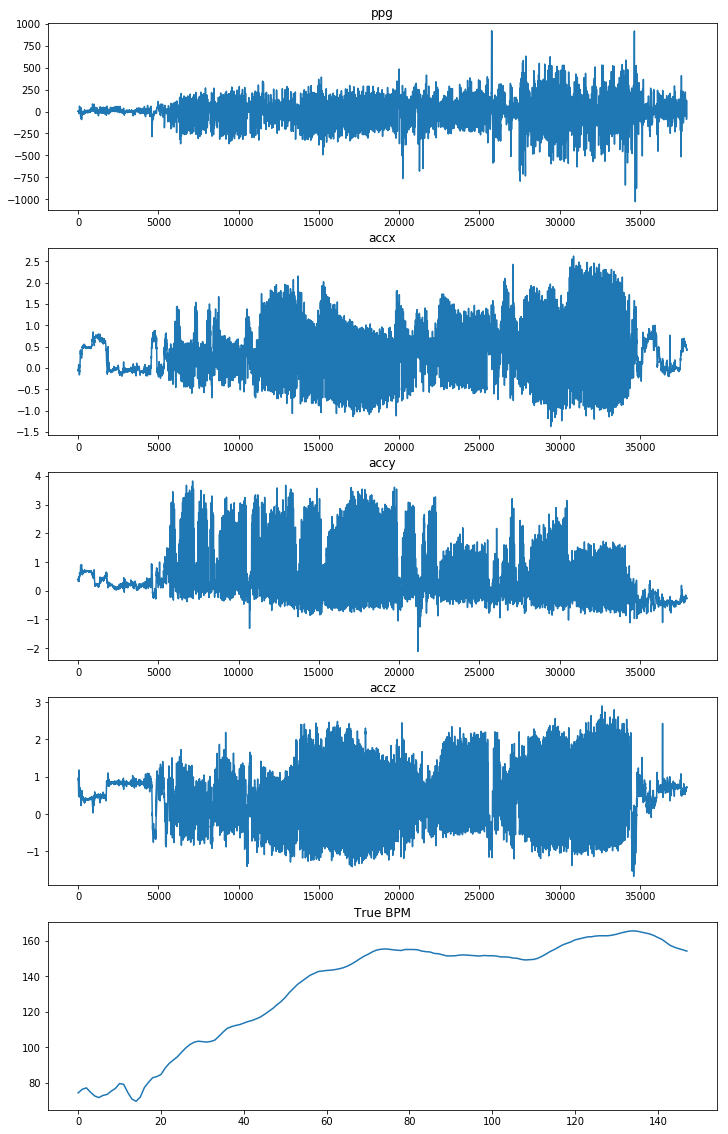

In [20]:
## Plot a data/ref example
idx = 0

data_sample = LoadTroikaDataFile(data_fls[idx])
ref_sample = sp.io.loadmat(ref_fls[idx])['BPM0']

ppg = data_sample[0]
accx = data_sample[1]
accy = data_sample[2]
accz = data_sample[3]
acc = np.sqrt(np.square(accx) + np.square(accy) + np.square(accz))
y_true = ref_sample

plt.figure(figsize=(12,20))
plt.subplot(5,1,1)
plt.plot(ppg) # ppg
plt.title("ppg")

plt.subplot(5,1,2)
plt.plot(accx) # accx
plt.title("accx")

plt.subplot(5,1,3)
plt.plot(accy) # accy
plt.title("accy")

plt.subplot(5,1,4)
plt.plot(accz) # accz
plt.title("accz")

plt.subplot(5,1,5)
plt.plot(y_true) # true y
plt.title("True BPM")

plt.show()


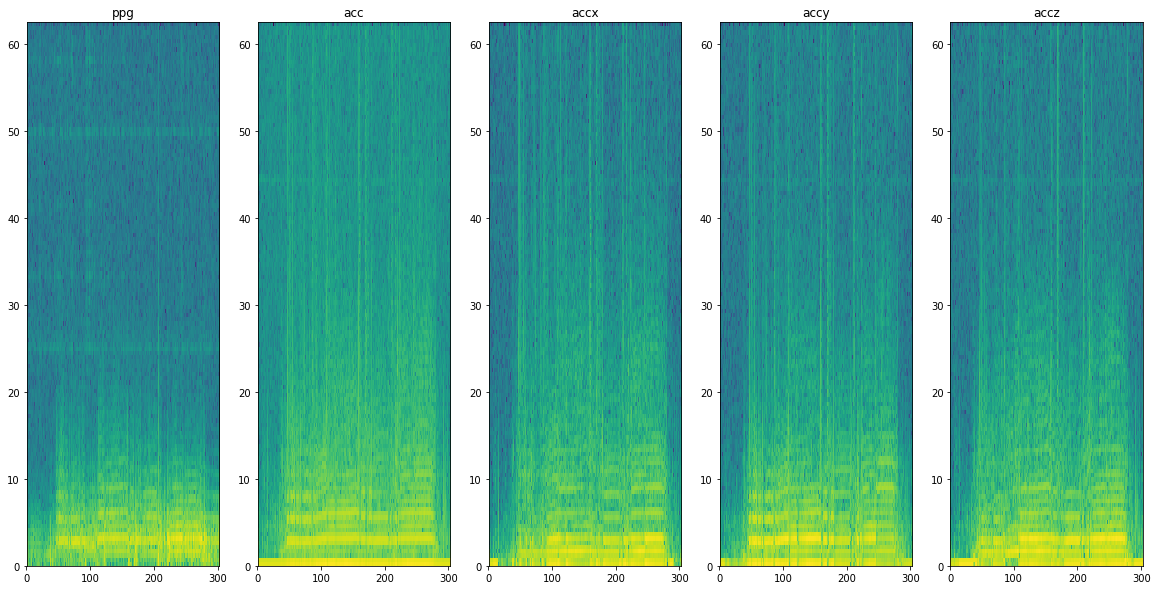

In [21]:
## Plot spectrogram
plt.figure(figsize=(20, 10))

plt.subplot(1,5,1)
plt.specgram(ppg, Fs=125.0)
plt.title('ppg')

plt.subplot(1,5,2)
plt.specgram(acc, Fs=125.0)
plt.title('acc')

plt.subplot(1,5,3)
plt.specgram(accx, Fs=125.0)
plt.title('accx')

plt.subplot(1,5,4)
plt.specgram(accy, Fs=125.0)
plt.title('accy')

plt.subplot(1,5,5)
plt.specgram(accz, Fs=125.0)
plt.title('accz')

plt.show()